In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
import numpy as np

from model import MLP, MLP_RES, CNN_RES
from dataset import BurgersDatasetBPTT, train_split_files

from utils import clear_memory

from config import (
    DATA_DIR,
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    EPOCHS,
    BATCH_SIZE,
    LR,
    SPLIT,
	UNROLL_STEPS
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training with unroll steps: 5
Learning Rate: 5e-05
Found 200 simulations.
Splitting into 140 training and 60 validation files.
Starting training...
New best model found at epoch 1 with val loss 0.021161
Epoch 1, Train Loss: 0.036762, Val Loss: 0.021161, LR: 5.00e-05
New best model found at epoch 2 with val loss 0.006327
Epoch 2, Train Loss: 0.026185, Val Loss: 0.006327, LR: 5.00e-05
Epoch 3, Train Loss: 0.022385, Val Loss: 0.012735, LR: 4.98e-05
Epoch 4, Train Loss: 0.018832, Val Loss: 0.008627, LR: 4.96e-05
Epoch 5, Train Loss: 0.020212, Val Loss: 0.008293, LR: 4.92e-05
Epoch 6, Train Loss: 0.018762, Val Loss: 0.013037, LR: 4.88e-05
Epoch 7, Train Loss: 0.019022, Val Loss: 0.007739, LR: 4.82e-05
Epoch 8, Train Loss: 0.018017, Val Loss: 0.008864, LR: 4.76e-05
New best model found at epoch 9 with val loss 0.005947
Epoch 9, Train Loss: 0.018128, Val Loss: 0.005947, LR: 4.69e-05
Epoch 10, Train Loss: 0.017844, Val Loss: 0.007969, LR: 4.61e-05
Epoch 11, Train Loss: 0.015117, Val Loss: 0.00

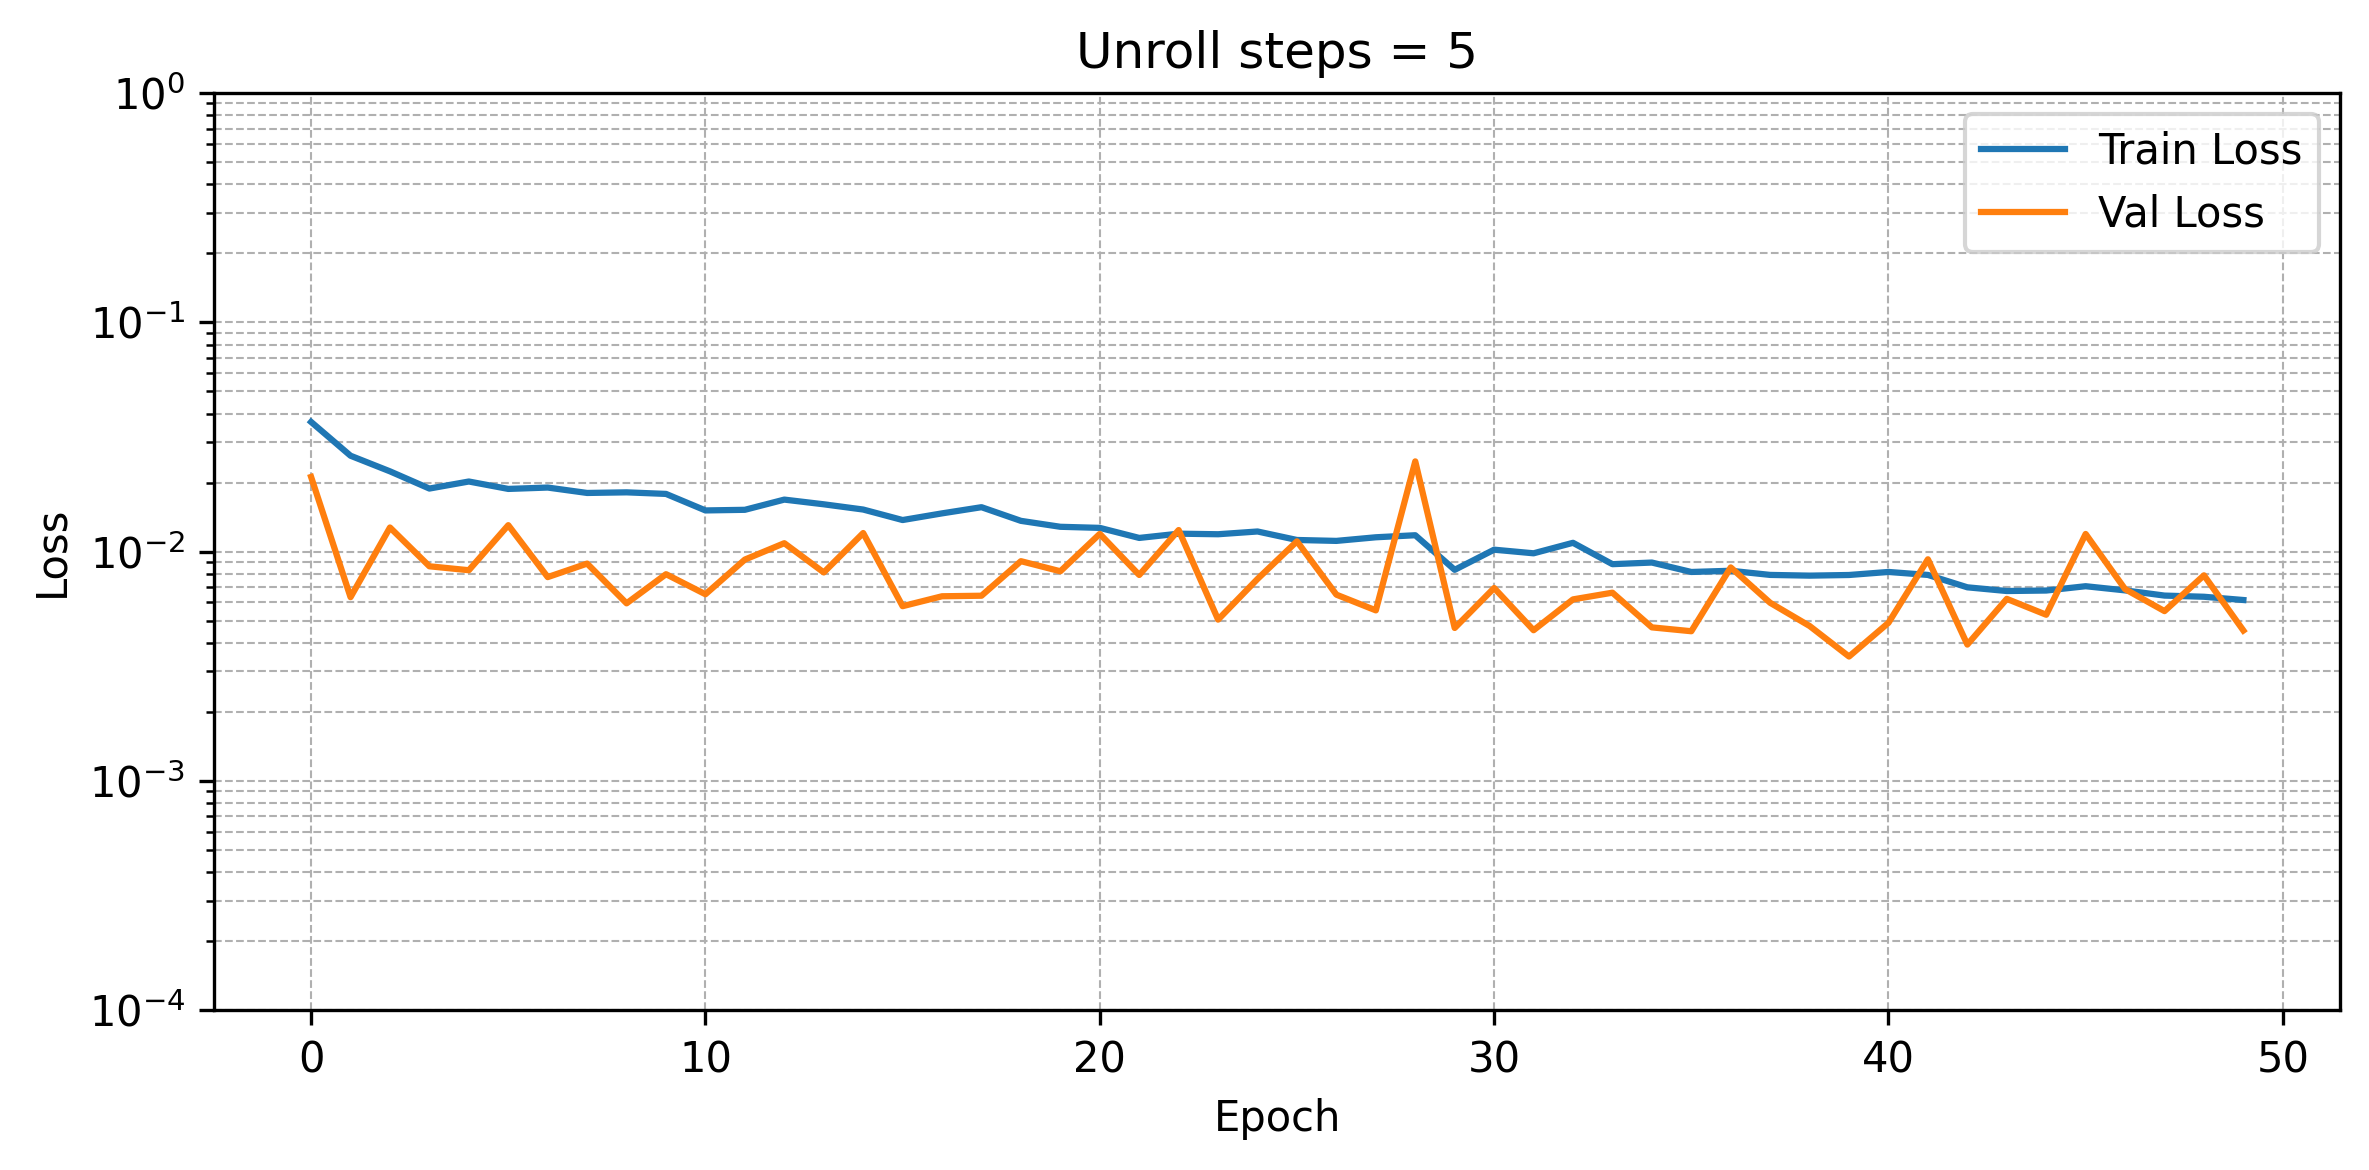

Model validation Loss over 5 steps: 0.003486
Model validation Loss over full sequence: 0.218742
CUDA before -> allocated: 93 MB, reserved: 1252 MB
CUDA after  -> allocated: 93 MB, reserved: 302 MB
Remaining live CUDA tensors: 298


/home/dan/venvs/torch/lib/python3.11/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [ ]:
from utils import clear_memory
from model import pad_with_ghost_cells

NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5
LR = 5e-5
EPOCHS = 50
EARLY_STOPPING = 30

UNROLL_STEPS=3
checkpoint_name = "CNN_RES_UNROLL_5_DGalerkin"
fine_tune = False # continue training the same model

unroll_array =[5]
# unroll_array = unroll_array[-2::]
# unroll_array = unroll_array[::-1]
val_loss_array = []
val_loss_full_array = []


for UNROLL_STEPS in unroll_array:
    print(f"Training with unroll steps: {UNROLL_STEPS}")
    print(f"Learning Rate: {LR}")

    # ---------------------------------------------------------------- #

    train_files, val_files = train_split_files()

    train_dataset = BurgersDatasetBPTT(file_paths=train_files, unroll_steps=UNROLL_STEPS)
    val_dataset = BurgersDatasetBPTT(file_paths=val_files, unroll_steps=UNROLL_STEPS)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # ---------------------------------------------------------------- #

    def unroll_loss(x, y, unroll_steps=UNROLL_STEPS):
        if unroll_steps == -1:
            unroll_steps = y.shape[1]

        max_step_loss = 1.0
        loss = torch.tensor(0.0, device=device)
        prev_step = x

        for i in range(unroll_steps):

            # zero gradient boundary conditions
            bc_left = prev_step[:, :1]
            bc_right = prev_step[:, -1:]

            padded_input = pad_with_ghost_cells(prev_step, bc_left, bc_right)
            y_pred = model(padded_input)

            step_loss = torch.clamp(criterion(y_pred, y[:, i]), max=max_step_loss) # gradient clipping
            loss += step_loss
            prev_step = y_pred
            
        return loss / unroll_steps

    def train_bptt(criterion, optimizer, scheduler, model, train_loader, val_loader, device, UNROLL_STEPS, EPOCHS, EARLY_STOPPING):
        unroll_steps = UNROLL_STEPS
        early_stopping = EARLY_STOPPING
        max_gradient_norm = 1.0

        best_epoch = 0
        best_val_loss = float("inf")
        current_lr = optimizer.param_groups[0]['lr']

        loss_history = {"train": [], "val": []}
        print("Starting training...")

        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0.0
            for x, y in train_loader:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                loss = unroll_loss(x, y, unroll_steps)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_gradient_norm)  # gradient clipping
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(device)
                    y = y.to(device)
                    # y_pred = model(x)
                    # val_loss += criterion(y_pred, y).item()
                    loss = unroll_loss(x, y, unroll_steps)
                    val_loss += loss.item()

            avg_train = train_loss / len(train_loader)
            avg_val = val_loss / len(val_loader)

            if avg_val < best_val_loss:
                best_val_loss = avg_val
                best_epoch = epoch
                best_lr = current_lr 
                best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
                print(f"New best model found at epoch {epoch+1} with val loss {best_val_loss:.6f}")

            # Get the current learning rate from the optimizer
            current_lr = optimizer.param_groups[0]['lr']
            
            print(
                f"Epoch {epoch+1}, "
                f"Train Loss: {avg_train:.6f}, "
                f"Val Loss: {avg_val:.6f}, "
                f"LR: {current_lr:.2e}"
            )

            loss_history["train"].append(avg_train)
            loss_history["val"].append(avg_val)

            # Step the scheduler at the end of each epoch
            scheduler.step()

            if epoch - best_epoch > early_stopping:
                print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
                break

        # Load best model weights
        model.load_state_dict(best_model_wts)

        print("Finished training.")

        loss_history["best_lr"] = best_lr

        return loss_history

    model = CNN_RES(
        hidden_channels=HIDDEN_SIZE,
        num_blocks=NUM_RES_BLOCKS,
        kernel_size=KERNEL_SIZE
    )
    
    if checkpoint_name is not None:
        model.load_state_dict(torch.load(f"models/{checkpoint_name}.pth", weights_only=True)) # pre-trained model
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-11)

    model_name = "CNN_RES_UNROLL_" + str(UNROLL_STEPS)
    checkpoint_name = model_name

    if not os.path.exists(f"models/{model_name}.pth") or fine_tune:
        loss_history = train_bptt(criterion, optimizer, scheduler, model, train_loader, val_loader, device, UNROLL_STEPS, EPOCHS, EARLY_STOPPING)
        torch.save(model.state_dict(), f"models/{model_name}.pth")
        print(f"Model saved")

        last_lr = loss_history["best_lr"]
        clamp = lambda x, min_v, max_v: max(min_v, min(x, max_v))
        LR = clamp(last_lr, 1e-12, 1e-5) # LR for next model

        if not fine_tune:
            #save loss_history to file
            with open(f"models/loss_{model_name}.txt", "w") as f:
                for key, values in loss_history.items():
                    f.write(f"{key}: {values}\n")

            plt.figure(figsize=(8, 4), dpi=300)
            plt.plot(loss_history["train"], label="Train Loss")
            plt.plot(loss_history["val"], label="Val Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Unroll steps = {UNROLL_STEPS}")
            plt.yscale("log")
            plt.tight_layout()
            plt.grid(which="both", linestyle="--", linewidth=0.5)
            plt.legend()
            plt.ylim(1e-4, 1e-0)
            plt.tight_layout()
            plt.savefig(f"models/loss_{model_name}.png")
            plt.show()

    else:
        model.load_state_dict(torch.load(f"models/{model_name}.pth", weights_only=True))
        model.eval()
        print("Model loaded")

    # ---------------------------------------------------------------- #

    #evaluate model on val_loader
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            loss = unroll_loss(x, y, UNROLL_STEPS)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_array.append(avg_val_loss)
    print(f"Model validation Loss over {UNROLL_STEPS} steps: {avg_val_loss:.6f}")

    # full rollout
    val_dataset = BurgersDatasetBPTT(file_paths=val_files, unroll_steps=-1)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            loss = unroll_loss(x, y, -1)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_full_array.append(avg_val_loss)
    print(f"Model validation Loss over full sequence: {avg_val_loss:.6f}")

    clear_memory()

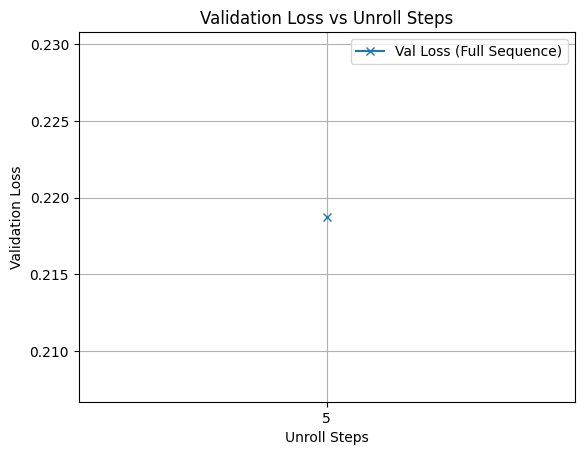

In [12]:
plt.plot(unroll_array, val_loss_full_array, marker='x', label='Val Loss (Full Sequence)')
plt.xticks(unroll_array)
plt.xlabel("Unroll Steps")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Unroll Steps")
plt.legend()
plt.grid()
plt.show()

In [23]:
UNROLL_STEPS = 5
checkpoint_name = f"CNN_RES_UNROLL_{UNROLL_STEPS}.pth"
model.load_state_dict(torch.load(f"models/{model_name}.pth", weights_only=True))
model.eval()

CNN_RES(
  (conv_in): Conv1d(1, 256, kernel_size=(1,), stride=(1,), bias=False)
  (bn_in): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_blocks): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(256, 256, kernel_size=(5,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), bias=False)
      (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(256, 256, kernel_size=(5,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), bias=False)
      (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock1D(
      (conv1): Conv1d(256, 256, ke

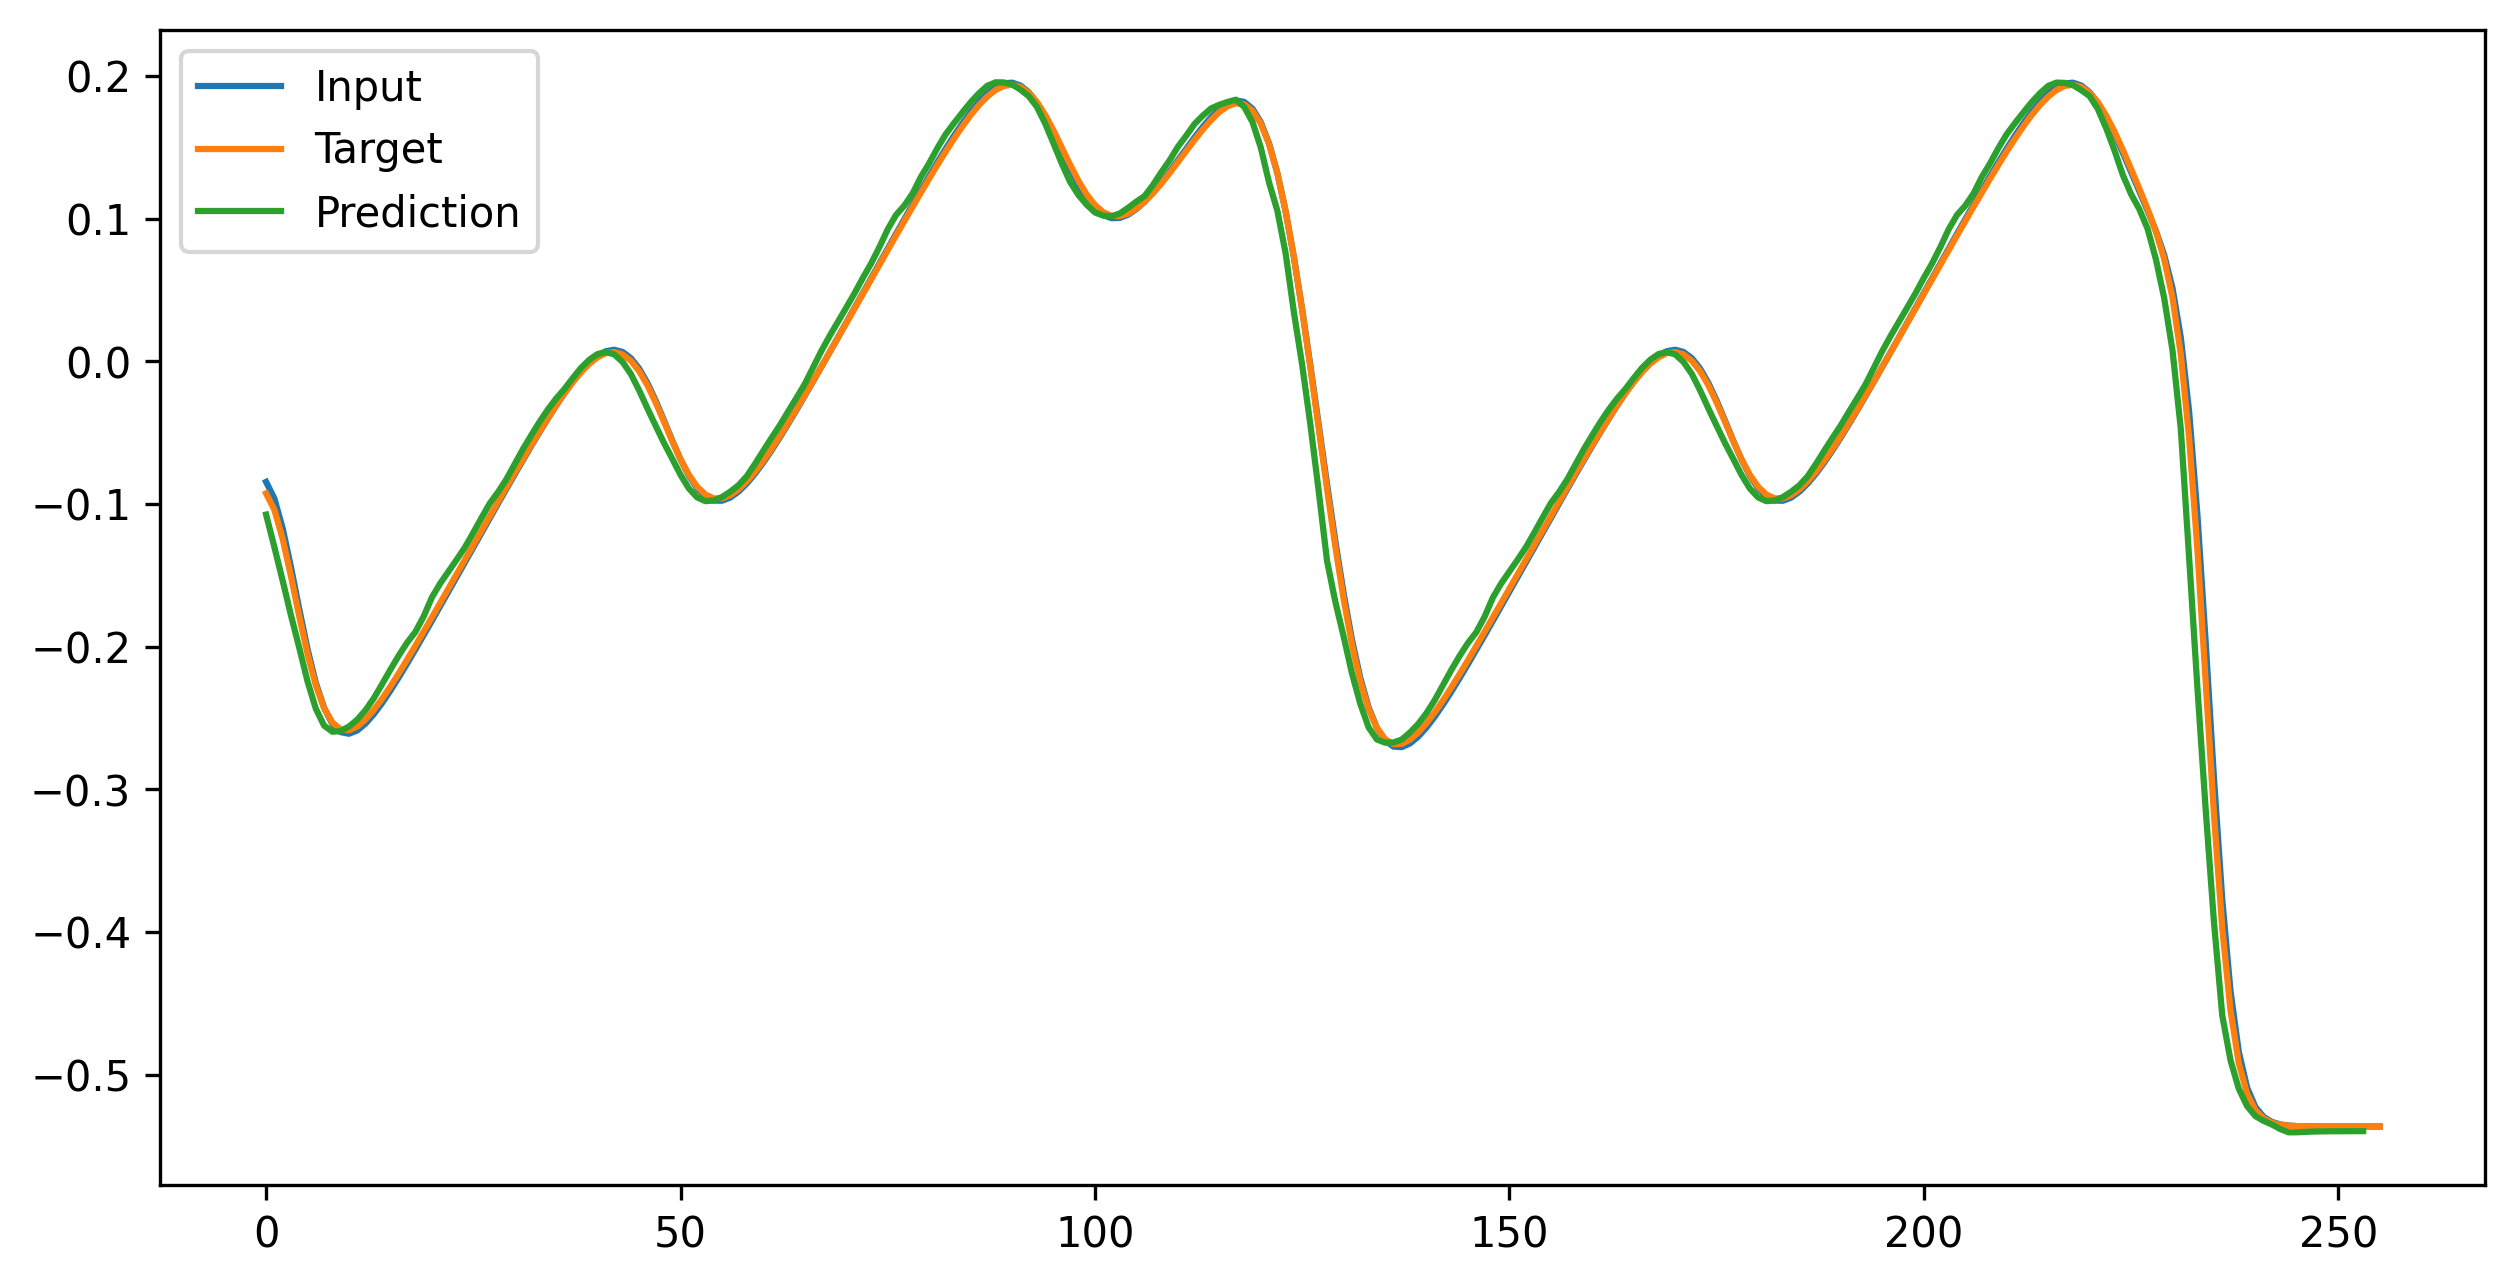

In [39]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample

x = x.to(device)
y = y.to(device)

with torch.no_grad():
	y_pred = model(x)
	
y_pred = y_pred.cpu()
x = x.cpu()
y = y.cpu()
#plot 
plt.figure(figsize=(10,5), dpi=300)
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0][0].numpy(), label='Target')
plt.plot(y_pred[0], label='Prediction')
plt.legend()

Rollout MSE over 98 steps: 0.823054


/tmp/ipykernel_266781/3984815607.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.875]) # Adjust layout to make space for the main title


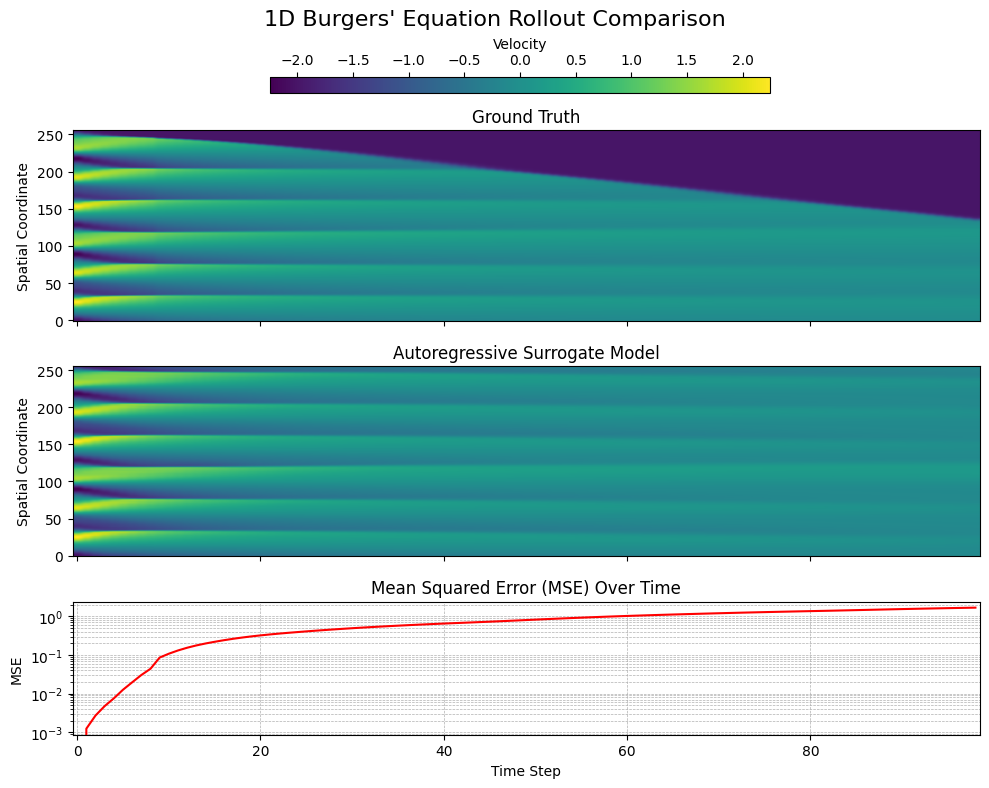

In [19]:
import numpy as np
import os

model.eval()

npz_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
if not npz_files:
    print("No .npz files found for evaluation.")
    
file_num = np.random.randint(0, len(npz_files) - 1)
data_path = os.path.join(DATA_DIR, npz_files[file_num])
raw_data = np.load(data_path)['Solver-Mesh-1D-Internal']

rollout_steps = raw_data.shape[0] - 1

start_index = 0

x0_np = raw_data[start_index]
ground_truth = raw_data[start_index : start_index + rollout_steps + 1]

predictions = [x0_np]
current_x = torch.from_numpy(x0_np).float().unsqueeze(0).to(device)

with torch.no_grad():
    for _ in range(rollout_steps):
        bc_left = current_x[:, -1:]
        bc_right = current_x[:, :1]
        padded_input = pad_with_ghost_cells(current_x, bc_left, bc_right)
        
        y_pred = model(padded_input)

        predictions.append(y_pred.squeeze().cpu())
        current_x = y_pred

predictions = np.array(predictions)
mse = np.mean((predictions - ground_truth)**2)

# --- 1. Calculate all necessary data for plotting ---
mse_over_steps = np.mean((predictions - ground_truth)**2, axis=1)
print(f"Rollout MSE over {rollout_steps} steps: {mse_over_steps.mean():.6f}")

# Determine the shared color limits
vmin = ground_truth.min()
vmax = ground_truth.max()


# --- 2. Create a 3x1 subplot layout with a shared X-axis ---
# The key change is sharex=True, which links the x-axes of all subplots.
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True,
                         gridspec_kw={'height_ratios': [1, 1, 0.7]}) # Give less height to the MSE plot

# --- Plot 1: Ground Truth (now on top) ---
im = axes[0].imshow(ground_truth.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='viridis')
axes[0].set_title('Ground Truth')
axes[0].set_ylabel('Spatial Coordinate')

# --- Plot 2: Surrogate Rollout (in the middle) ---
axes[1].imshow(predictions.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='viridis')
axes[1].set_title('Autoregressive Surrogate Model')
axes[1].set_ylabel('Spatial Coordinate')

# --- Plot 3: MSE over Time Steps (at the bottom) ---
axes[2].plot(mse_over_steps, color='r')
axes[2].set_title('Mean Squared Error (MSE) Over Time')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('MSE')
axes[2].set_yscale("log")
axes[2].grid(True, which="both", linestyle="--", linewidth=0.5)
# Set explicit x-axis limits to match the imshow extent
axes[2].set_xlim(-0.5, len(mse_over_steps) - 0.5)

# --- THE KEY CHANGES START HERE ---

# --- 3. Manually create a new axis for the colorbar ---
# The rectangle's coordinates are in "figure fractions" (0 to 1).
# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.275, 0.875, 0.5, 0.02]) # Positioned at the top

# --- 4. Draw the colorbar into the new axis using the `cax` argument ---
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Velocity')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')


fig.tight_layout(rect=[0, 0, 1, 0.875]) # Adjust layout to make space for the main title
fig.suptitle(f"1D Burgers' Equation Rollout Comparison", fontsize=16)

# Save and show the combined figure
plt.savefig('rollout_comparison.svg', dpi=300)
plt.show()